## 1. Business understanding

### Objectives

Perform sentiment analysis of tweets in real time.

### Success criteria

The project will be considered successful if the resulting model will work with accuracy of 70% or higher. Results should be produced with a delay no bigger than 1 second.

### Project plan

1. Examine the data provided by the Twitter Streaming API.
1. Fetch a set of tweets that will be used for training purposes.
1. Explore the data gathered in the sample.
1. Label the training data
1. Build and evaluate models
1. Create a spark job that will use the best prediction model
1. Deploy the job to a preset spark cluster

## 2. Data understanding

### Collect data
Fetch tweets using the Twitter Streaming API and store them in Kafka.

In [20]:
from notebook_client.notebook_client import NotebookClient

In [21]:
nc = NotebookClient()
nc.initialize_producers_manager_connection()
nc.initialize_sampler_manager_connection()

In [322]:
producer_pid = nc.start_streaming('usa_stream', { 'locations': '-125.75,30.8,-70,45' })

In [47]:
reservoir_size = 5
limit = 10
nc.start_sampling('san_stream', 'london_sample', reservoir_size, limit)

In [317]:
nc.streaming_status(producer_pid)

'not found'

In [50]:
nc.sampling_status()

'finished'

In [338]:
nc.stop_streaming(producer_pid)

'stopped'

In [43]:
nc.stop_sampling()

'stopped'

#### Load collected data from Kafka

In [22]:
from kafka import KafkaConsumer

consumer = KafkaConsumer('usa_stream', bootstrap_servers='kafka')
consumer.topics()
partition = consumer.assignment().pop()

In [23]:
consumer.seek_to_end()
tweets_count = consumer.position(partition)
consumer.seek_to_beginning()

In [17]:
tweets_count

808336

In [24]:
import json

In [25]:
data = map(lambda t: json.loads(t.value.decode('utf-8')), consumer)

#### Check what a sample tweet object looks like.

In [20]:
data.__next__()

{'contributors': None,
 'coordinates': None,
 'created_at': 'Thu Aug 31 10:41:10 +0000 2017',
 'display_text_range': [0, 55],
 'entities': {'hashtags': [{'indices': [11, 29], 'text': 'TrinidadandTobago'},
   {'indices': [31, 38], 'text': 'Repost'}],
  'media': [{'display_url': 'pic.twitter.com/tUZbpY8meO',
    'expanded_url': 'https://twitter.com/dyschick/status/903206020339699713/video/1',
    'id': 903205935727779840,
    'id_str': '903205935727779840',
    'indices': [56, 79],
    'media_url': 'http://pbs.twimg.com/ext_tw_video_thumb/903205935727779840/pu/img/79Rjyir-dcmfFMRs.jpg',
    'media_url_https': 'https://pbs.twimg.com/ext_tw_video_thumb/903205935727779840/pu/img/79Rjyir-dcmfFMRs.jpg',
    'sizes': {'large': {'h': 640, 'resize': 'fit', 'w': 640},
     'medium': {'h': 600, 'resize': 'fit', 'w': 600},
     'small': {'h': 340, 'resize': 'fit', 'w': 340},
     'thumb': {'h': 150, 'resize': 'crop', 'w': 150}},
    'type': 'photo',
    'url': 'https://t.co/tUZbpY8meO'}],
  'symbol

Tweet objects contain a lot of properties useless in our case. The two meaningful fields are _id_ (numeric) and _text_ (string).

#### Extract useful properties and load them into a data frame.

In [26]:
def parse_tweet(data):
    return { 'id': data.get('id'), 'text': data.get('text') }

In [27]:
import pandas as pd

pd.set_option("display.max_colwidth", 150)

In [28]:
consumer.seek_to_beginning()
data = map(lambda t: json.loads(t.value.decode('utf-8')), consumer)
parsed_data = map(lambda x: parse_tweet(x), data)
df = pd.DataFrame([parsed_data.__next__() for i in range(tweets_count)])

#### Explore the data

In [29]:
df.head()

,id,text
0,9.032060e+17,Happy 55th #TrinidadandTobago!\n#Repost @RemyRemBunction https://t.co/tUZbpY8meO
1,9.032060e+17,Stupid Easy Trivia happens now with @toddandjayde! Play with us to CLAIM YOUR THRONE!
2,9.032060e+17,Yes but I miss Hillary more https://t.co/FS4hJTVzTl
3,9.032060e+17,"Just posted a photo @ Gladstone, Missouri https://t.co/YFpvmBPTxs"
4,9.032060e+17,i have so much fun here. wish you were here. https://t.co/DvBlLLXEV3


In [86]:
df.tail()

,id,text
808330,9.039561e+17,Lmaooooooo https://t.co/CyyZewelQL
808331,9.039561e+17,"These last 2 days, boyyyyy. Have been the worst."
808332,9.039561e+17,This nigga is tweeting like he know me. All I said was shut up and he tweeted me 4 times lmaooooooooo https://t.co/4GI3Ogykrd
808333,9.039561e+17,"If you're looking for work in #MtPleasant, MI, check out this #job: https://t.co/Ik6kX1FChQ #CustomerService #Hiring #CareerArc"
808334,9.039561e+17,Haha to funny 😂 https://t.co/UoqVOjj06a


In [95]:
df.sample()

,id,text
232069,9.033540e+17,I'm literally my worst enemy.


In [156]:
df['text'].describe()

count     807271
unique    800093
top          Lol
freq          70
Name: text, dtype: object

Number of empty entries.

In [157]:
no_id = df[df['id'].isnull()].size
no_text = df[df['text'].isnull()].size
print("Entries without id: {0}".format(no_id))
print("Entries without text: {0}".format(no_text))

Entries without id: 2130
Entries without text: 2130


Word count statistics.

In [124]:
nn_df = df[df['id'].notnull()]
nn_df = nn_df[df['text'].notnull()]
nn_df['text'].str.split().apply(len).describe()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


count    807270.000000
mean         11.346310
std           6.729883
min           1.000000
25%           6.000000
50%          11.000000
75%          16.000000
max          69.000000
Name: text, dtype: float64

In [135]:
corpus = set()
nn_df['text'].str.lower().str.split().apply(corpus.update)
print("Corpus size (before cleaning it up): {}".format(len(corpus)))
del corpus

Corpus size (before cleaning it up): 1017250


#### Data quality report
The data is rather complete. Only 2130 entries are incomplete (lacking text and id) and therefore should be excluded from further analysis. Text data contain lots of hashtags, emojis, urls, etc. This should be taken into consideration during the text cleaning part.

## 3. Data preparation

In order to reduce memory usage and facilitate inspecting the text data, tweet properties that will be utilized to build a classification model have been chosen beforehand, after initial overview of Twitter Streaming API response.

#### Cleaning the text data
Remove entries that contain null values

In [30]:
df = df[df['id'].notnull()]
df = df[df['text'].notnull()]

Convert ids to integers

In [31]:
df['id'] = df['id'].apply(int)

In [34]:
df.head()

,id,text
0,903206020339699712,Happy 55th #TrinidadandTobago!\n#Repost @RemyRemBunction https://t.co/tUZbpY8meO
1,903206024332660736,Stupid Easy Trivia happens now with @toddandjayde! Play with us to CLAIM YOUR THRONE!
2,903206024638816256,Yes but I miss Hillary more https://t.co/FS4hJTVzTl
3,903206028006883328,"Just posted a photo @ Gladstone, Missouri https://t.co/YFpvmBPTxs"
4,903206026643611648,i have so much fun here. wish you were here. https://t.co/DvBlLLXEV3


Use id as index

In [36]:
df.set_index('id', inplace=True)

In [32]:
df.head()

,id,text
0,903206020339699712,Happy 55th #TrinidadandTobago!\n#Repost @RemyRemBunction https://t.co/tUZbpY8meO
1,903206024332660736,Stupid Easy Trivia happens now with @toddandjayde! Play with us to CLAIM YOUR THRONE!
2,903206024638816256,Yes but I miss Hillary more https://t.co/FS4hJTVzTl
3,903206028006883328,"Just posted a photo @ Gladstone, Missouri https://t.co/YFpvmBPTxs"
4,903206026643611648,i have so much fun here. wish you were here. https://t.co/DvBlLLXEV3


#### Fetch labels from http://www.sentiment140.com

In [279]:
import json
from urllib.parse import urlencode
from urllib.request import Request, urlopen


def payload(df):
    data = { 'data': [{ 'text': e[1]['text'], 'id': e[1]['id'] } for e in df.iterrows()]}
    return json.dumps(data).encode('utf-8')


def fetch_labels(df):
    api_url = 'http://www.sentiment140.com/api/bulkClassifyJson'
    request = Request(api_url, payload(df), {'Content-Type': 'application/json'})
    response = urlopen(request).read().decode("utf-8", "replace")
    json_response = json.loads(response)
    return json_response['data']

Store labels in Cassandra for further use.

In [ ]:
from cassandra.cluster import Cluster

cluster = Cluster(['cassandra'])
session = cluster.connect()
session.execute("CREATE KEYSPACE sentiment_analysis WITH REPLICATION = { 'class' : 'SimpleStrategy', 'replication_factor' : 1 };")
session.set_keyspace('sentiment_analysis')
session.execute("CREATE TABLE sentiment_labels(id text PRIMARY KEY, sentiment int)")
cluster.shutdown()

In [277]:
def convert_label(polarity):
    return { 0: -1, 2: 0, 4: 1}[polarity]


def store_label(sentiment_data, session):
    session.execute("""
        INSERT INTO sentiment_labels (id, sentiment)
        VALUES (%s, %s)""",
        (str(sentiment_data['id']), convert_label(sentiment_data['polarity']))
    )

In [281]:
cluster = Cluster(['cassandra'])
session = cluster.connect('sentiment_analysis')

In [ ]:
chunk_size = 100
for i in range(379840, df['text'].size - chunk_size + 1, chunk_size):
    labels = fetch_labels(df[i:i+chunk_size])
    for l in labels:
        store_label(l, session)
    print(i)

In [ ]:
cluster.shutdown()

#### Load labels into the dataframe

In [72]:
from cassandra.cluster import Cluster


cluster = Cluster(['cassandra'])
session = cluster.connect('sentiment_analysis')

In [51]:
def pandas_factory(colnames, rows):
    return pd.DataFrame(rows, columns=colnames)

In [73]:
session.row_factory = pandas_factory
session.default_fetch_size = None

query = "SELECT * FROM sentiment_labels"
result = session.execute(query, timeout=None)
labels_df = result._current_rows

In [74]:
cluster.shutdown()

In [41]:
labels_df.sample()

,id,sentiment
367132,903396912845512704,0


In [58]:
labels_df.set_index('id', inplace=True)

In [42]:
labels_df.head()

,id,sentiment
0,903368428244926464,0
1,903370282064326656,0
2,903363400725520384,0
3,903335866411741184,0
4,903435914361298944,0


Store dataframes in csv files for convenient access.

In [76]:
df.to_csv('tweets_df.csv')

In [81]:
labels_df.to_csv('labels_df.csv')

In [18]:
df = pd.read_csv('tweets_df.csv')
labels_df = pd.read_csv('labels_df.csv')

In [80]:
labels_df = labels_df.sort_values(by='id')

In [96]:
df = df.sort_values(by='id')

In [114]:
labels_df.tail()

,id,sentiment
541595,903956065158615040,-1
792664,903956065678745600,0
539600,903956068203601920,0
85937,903956068644081664,0
462642,903956068761452544,0


In [106]:
labels_df['sentiment'].values

array([1, 0, 0, ..., 0, 0, 0])

In [110]:
df = df.drop_duplicates(subset='id', keep="last")

In [112]:
df['label'] = labels_df['sentiment'].values

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [115]:
df.tail()

,id,text,label
808331,903956065158615040,"These last 2 days, boyyyyy. Have been the worst.",-1
808332,903956065678745600,This nigga is tweeting like he know me. All I said was shut up and he tweeted me 4 times lmaooooooooo https://t.co/4GI3Ogykrd,0
808333,903956068203601920,"If you're looking for work in #MtPleasant, MI, check out this #job: https://t.co/Ik6kX1FChQ #CustomerService #Hiring #CareerArc",0
808334,903956068644081664,Haha to funny 😂 https://t.co/UoqVOjj06a,0
808335,903956068761452544,"See our latest #Douglas, GA #job and click to apply: Delivery Driver - https://t.co/AownKm7yjW #Transportation #Hiring #CareerArc",0


In [116]:
df.to_csv('train.csv')

Explore data once more.

In [118]:
import matplotlib.pyplot as plt

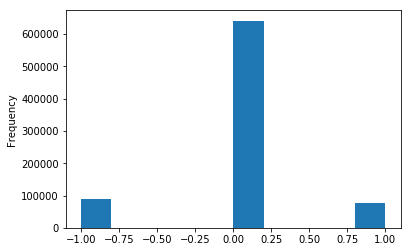

In [121]:
df['label'].plot.hist()
plt.show()

Clean data.
- remove entries without labels
- remove stopwords

Build model using NaiveBayes classifier and HashingTF.